<a href="https://colab.research.google.com/github/stephenbaek/dlcourse/blob/main/assignments/a2_mnist.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

# Final Project

The goal is to take images that show five letters and/or numbers, along with labels showing the true values of those five letters/numbers, and use them to train a convolutional neural network. The ultimate goal is the prediction of the labels of a test dataset.

##Import necessary modules

In [1]:
import tensorflow as tf
import pathlib
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from keras import backend as K

##We'll need this list for the encoding and decoding later

In [2]:
#Our list of possible characters
import string
charList = list(string.ascii_lowercase + string.ascii_uppercase + string.digits)

##Get sample data

In [3]:
#Get the data from my GitHub repository.
#This will throw a message "fatal: destination path 'ISE6380' already exists and is not an empty directory."
#if it is run two or more times. It does not affect the execution of any other code within this cell. 
#It can be commented out after the first time running this cell.
!git clone https://github.com/JonathonHowland/ISE6380

#Get the file names and files
names = tf.data.Dataset.list_files("/content/ISE6380/archive/*.jpg", shuffle=False)
images = names.map(lambda x: tf.io.decode_jpeg(tf.io.read_file(x)))

#Check to make sure that all 23764 names and images were obtained
print(len(images))
print(len(names))

Cloning into 'ISE6380'...
remote: Enumerating objects: 23922, done.
remote: Counting objects: 100% (23744/23744), done.
remote: Compressing objects: 100% (23743/23743), done.
remote: Total 23922 (delta 1), reused 23743 (delta 1), pack-reused 178
Receiving objects: 100% (23922/23922), 73.97 MiB | 29.98 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (23957/23957), done.
23764
23764


### Multi-hot encoding

I couldn't figure out a way to do the encoding (it's not truly one-hot encoding) in TensorFlow, so I did it manually. The logic is as follows: Each character can have 1 of 62 values (a-z, A-Z, 0-9). There are 5 characters per CAPTCHA. Thus, my encoded label is a 310 dimensional vector, with one value of 1 per 62 values. Effectively, it is five one-hot encoded vectors put together.

In [4]:
#Manually encode the labels. The result is a 310 dimensional vector (62 possibilities times 5 positions)

def one_hot(labelList):
  oneHotList = []
  print(charList)
  for label in labelList:
    tempList = []
    for c in label:
      zeros = np.zeros(62)
      zeros[charList.index(c)] = 1.0
      tempList.extend(list(zeros))
    oneHotList.append(list(tempList))
  return oneHotList

###The names contain the full file path, where we just want the file name.

In [5]:
#We need the names as a list
nameList = list(names.as_numpy_iterator())
print(nameList)

#They're messy, so let's clean them up.
newNameList = []

for n in nameList:
  string = str(n)
  temp = string.split("/")[-1]
  newName = temp.split(".")[0]
  newNameList.append(newName)

#Much better
print(newNameList)

#Now, let's treat the string as a list of characters
charName = []
for name in newNameList:
  tempList = []
  for c in name:
    tempList.append(c)
  charName.append(tempList)

#Apply the encoding
labels = one_hot(charName)
    

[b'/content/ISE6380/archive/P7fmy.jpg', b'/content/ISE6380/archive/P7gRr.jpg', b'/content/ISE6380/archive/P7gtO.jpg', b'/content/ISE6380/archive/P7hgN.jpg', b'/content/ISE6380/archive/P7hrK.jpg', b'/content/ISE6380/archive/P7mik.jpg', b'/content/ISE6380/archive/P7pDp.jpg', b'/content/ISE6380/archive/P7qaQ.jpg', b'/content/ISE6380/archive/P7tPT.jpg', b'/content/ISE6380/archive/P7wg9.jpg', b'/content/ISE6380/archive/P7wm1.jpg', b'/content/ISE6380/archive/P7zdv.jpg', b'/content/ISE6380/archive/P81NX.jpg', b'/content/ISE6380/archive/P82QF.jpg', b'/content/ISE6380/archive/P84L3.jpg', b'/content/ISE6380/archive/P86N7.jpg', b'/content/ISE6380/archive/P878e.jpg', b'/content/ISE6380/archive/P88bp.jpg', b'/content/ISE6380/archive/P8CAD.jpg', b'/content/ISE6380/archive/P8E8Z.jpg', b'/content/ISE6380/archive/P8Fxj.jpg', b'/content/ISE6380/archive/P8G8c.jpg', b'/content/ISE6380/archive/P8H8G.jpg', b'/content/ISE6380/archive/P8Ha4.jpg', b'/content/ISE6380/archive/P8J9r.jpg', b'/content/ISE6380/archi

###Create dataset of images and labels

In [6]:
nameDs = tf.data.Dataset.from_tensor_slices(labels)

#Make the dataset
total_ds = tf.data.Dataset.zip((images, nameDs))

#Split it into training and test data
total_ds = total_ds.shuffle(len(total_ds))
train_ds = total_ds.take(int(0.8*len(total_ds)))
test_ds = total_ds.skip(int(0.8*len(total_ds)))

### Check to make sure images load properly

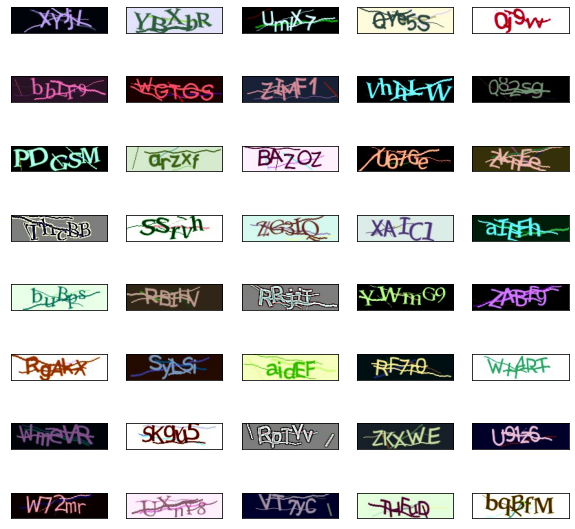

In [7]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds):
  if(i < 40):
    plt.subplot(8,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    #plt.xlabel(label.numpy().all())
plt.show()

###Normalize the pixel values between -1 and 1

In [8]:
def normalize(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = (image - 127.5)/127.5
  print(tf.reduce_max(image))
  return image, label

###Resize the images

In [9]:
#Let's go ahead and make the images 64x64 pixels
def resize(image, label):
  image = tf.image.resize(image, [64,64])
  return image, label

###Apply the preprocessing functions (normalization and resizing, we already encoded the values).

In [10]:
train_ds=train_ds.map(normalize)
train_ds=train_ds.map(resize)
test_ds=test_ds.map(normalize)
test_ds=test_ds.map(resize)

Tensor("Max:0", shape=(), dtype=float32)
Tensor("Max:0", shape=(), dtype=float32)


###Make batches.

In [11]:
train_ds=train_ds.shuffle(len(train_ds))
train_ds=train_ds.batch(64)
test_ds=test_ds.batch(64)

###Build the neural network architecture.

In [12]:
inputs = tf.keras.layers.Input(shape=(64, 64, 3))
x = tf.keras.layers.Conv2D(64, (5,5), padding="same")(inputs)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(64, (5,5), padding="same")(x)
x = tf.keras.layers.MaxPool2D(padding="same")(x)
x = tf.keras.layers.ReLU()(x)
#Dropout layer to prevent overfitting
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(64, (5,5), padding="same")(inputs)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(64, (5,5), padding="same")(x)
x = tf.keras.layers.MaxPool2D(padding="same")(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512)(x)
#Sigmoid activation to keep values between 0 and 1 to avoid explosions
outputs = tf.keras.layers.Dense(310, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
re_lu_3 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0     

###We need to use binary cross entropy here, as categorical cross entropy does not work for this problem. We'll also use from_logits=True, since the values are not strictly probabilities (though they are between 0 and 1).

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

###Loss plateaued at 20 epochs, and the testing accuracy was sufficient.

In [14]:
model.fit(train_ds, epochs=20)

Epoch 1/20
 68/298 [=====>........................] - ETA: 17:15 - loss: 0.1685 - accuracy: 0.0669

KeyboardInterrupt: ignored

In [ ]:
#Evaluate and predict on our test dataset
model.evaluate(test_ds)
predictions = model.predict(test_ds)

###We need to decode our predicted labels to determine the character predictions. This also allows us to decode our encoded true labels to manually inspect the accuracy.

In [ ]:
def decode(prediction):
  predArray = []
  charArray = []
  for i in range(5):
    temp = np.argmax(prediction[62*i:62*(i+1)])
    predArray.append(temp)
  for i in predArray:
    charArray.append(charList[i])
  return charArray

####The accuracy quoted in the training/testing process isn't what we're interested in. We want to know how many CAPTCHA's the model got right. So, we only count it correct if EVERY character in the prediction is the same as the true label. I've commented out the printing of the labels themselves, but left it in the code so you can check them if you want.

In [ ]:
countRight = 0
countWrong = 0
for (image, label) in test_ds:
  pred = list(model.predict(image))
  for i in range(len(pred)):
    if(decode(pred[i]) == decode(label[i])):
      countRight += 1
    else:
      countWrong += 1
  #print(decode(label[0]),decode(pred[0]))

In [ ]:
print("Number right: {}, Number wrong: {}, Accuracy: {}".format(countRight, countWrong, countRight/(countRight+countWrong)))